In [111]:
import string
import re
import os
import nltk
import pandas as pd
import numpy as np
import json
import glob
import gzip
import tensorflow as tf
from tensorflow import keras
import time

import matplotlib.pyplot as plt

SEED = 1013
np.random.seed(SEED)

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import pandas as pd 
import numpy as np 
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy import sparse
import os
import pickle
import emoji
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.util import ngrams

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Meghna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
import collections
df=pd.read_csv('/Users/Meghna/Desktop/tweets_for_language_model_noRT.csv')
df

,Unnamed: 0,races,tweets
0,0,0,And on the first day of the Colorado legislatu...
1,1,1,Everyone needs to read this. Dr. Nichols and h...
2,2,0,“He would make outrageous claims like he inven...
3,3,0,@holynext SUGAR AND COVID\nDiabetes is a targe...
4,4,1,I’m all for compromise - just do not give in o...
...,...,...,...
37199,37199,1,"There's great news about Covid vaccines, but w..."
37200,37200,1,@andybudd You're saying this like all travelli...
37201,37201,1,Oh they was beaten or pepper sprayed
37202,37202,1,Maine CDC prepares to distribute COVID-19 vacc...


In [113]:
races = df['races'].to_list()
count = 0
for val in races:
    if val == 1:
        count += 1
print(count)
df.head()

18602


,Unnamed: 0,races,tweets
0,0,0,And on the first day of the Colorado legislatu...
1,1,1,Everyone needs to read this. Dr. Nichols and h...
2,2,0,“He would make outrageous claims like he inven...
3,3,0,@holynext SUGAR AND COVID\nDiabetes is a targe...
4,4,1,I’m all for compromise - just do not give in o...


In [114]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+' #remove mentions
pat2 = r'https?://[^ ]+' #remove hyperlinks
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml') # remove html tags
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?") #remove byte order marks
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    stripped = re.sub(r'\@w+','',stripped)
    lower_case = stripped.lower()
    lower_case = emoji.demojize(lower_case, language='en')
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled) #remove hashtag
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [115]:
tweets = df['tweets'].to_list()
cleaned_tweets = []
for tweet in tweets:
    cleaned_tweets.append(tweet_cleaner_updated(tweet))

In [168]:
num_of_words = []
for tweet in cleaned_tweets:
    length = 0
    for word in tweet.split():
        if word != '':
            length += 1
    num_of_words.append(length)
    

In [169]:
avg_word_length = []
for tweet in cleaned_tweets:
    if tweet != '':
        lengths = []
        for word in tweet.split():
            if word != " ":
                lengths.append(len(word))
        avg_word_length.append(sum(lengths)/len(lengths))
    else:
        avg_word_length.append(0)

In [170]:
new_df = pd.DataFrame()
new_df['races'] = races
new_df['tweets'] = cleaned_tweets
new_df['num_of_words'] = num_of_words
new_df['avg_word_length'] = avg_word_length

In [171]:
new_df

,races,tweets,num_of_words,avg_word_length
0,0,and on the first day of the colorado legislatu...,27,5.148148
1,1,everyone needs to read this dr nichols and his...,15,4.266667
2,0,he would make outrageous claims like he invent...,11,5.090909
3,0,sugar and covid diabetes is target we eat too ...,37,4.729730
4,1,all for compromise just do not give in on the ...,24,4.791667
...,...,...,...,...
37199,1,there great news about covid vaccines but why ...,28,4.714286
37200,1,you re saying this like all travelling is non ...,46,4.673913
37201,1,oh they was beaten or pepper sprayed,7,4.285714
37202,1,maine cdc prepares to distribute covid vaccine...,23,5.913043


In [172]:
negative_tweets = new_df[new_df['races'] == 0]
positive_tweets = new_df[new_df['races'] == 1]

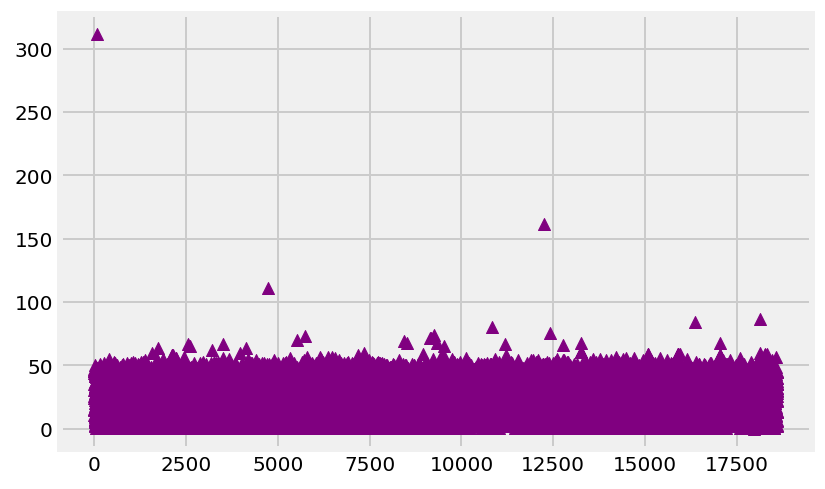

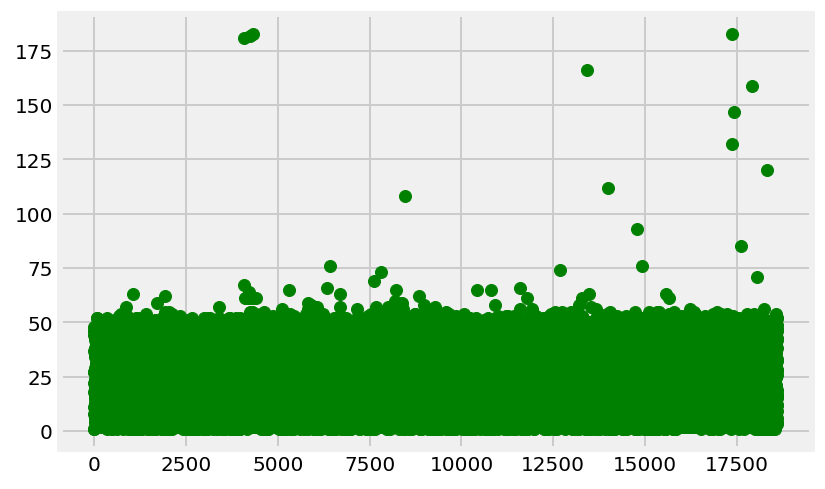

In [173]:
neg_tweets_num_of_words = negative_tweets['num_of_words'].to_list()
pos_tweets_num_of_words = positive_tweets['num_of_words'].to_list()
len(neg_tweets_num_of_words)
x_pos = [i for i in range(18602)]
x_neg = [i for i in range(18602)]
plt.scatter(x_pos, pos_tweets_num_of_words,  marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(x_neg, neg_tweets_num_of_words, marker='o',  color = 'green')
plt.show()

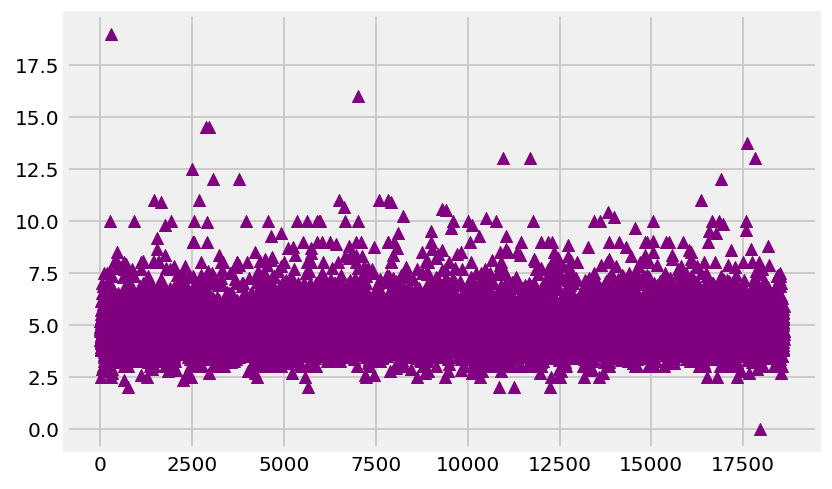

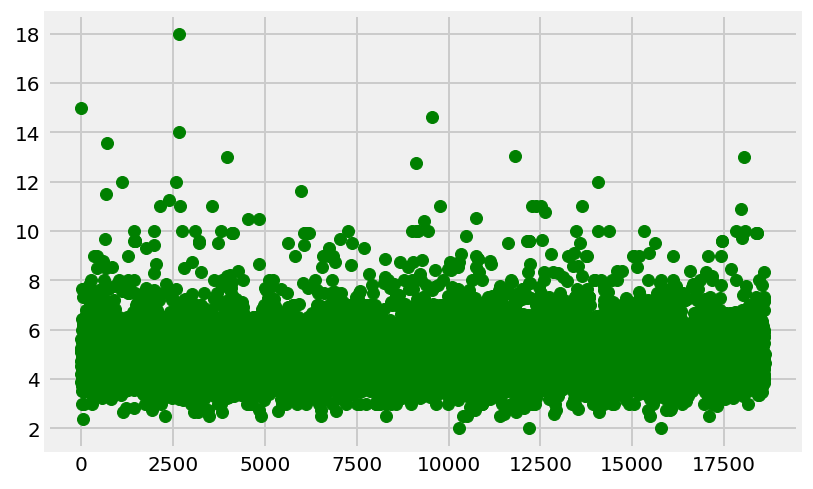

In [174]:
neg_tweets_avg_word_len = negative_tweets['avg_word_length'].to_list()
pos_tweets_avg_word_len = positive_tweets['avg_word_length'].to_list()
len(neg_tweets_num_of_words)
x_pos = [i for i in range(18602)]
x_neg = [i for i in range(18602)]
plt.scatter(x_pos, pos_tweets_avg_word_len,  marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(x_neg, neg_tweets_avg_word_len, marker='o', color = 'green')
plt.show()

In [175]:
df_num_words = pd.DataFrame()
negs = negative_tweets['num_of_words'].to_list()
pos = positive_tweets['num_of_words'].to_list()
df_num_words['neg_num_of_words'] = negs
df_num_words['pos_num_of_words'] = pos
df_num_words

,neg_num_of_words,pos_num_of_words
0,27,15
1,11,24
2,37,47
3,48,11
4,18,16
...,...,...
18597,38,28
18598,49,46
18599,46,7
18600,6,23


Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

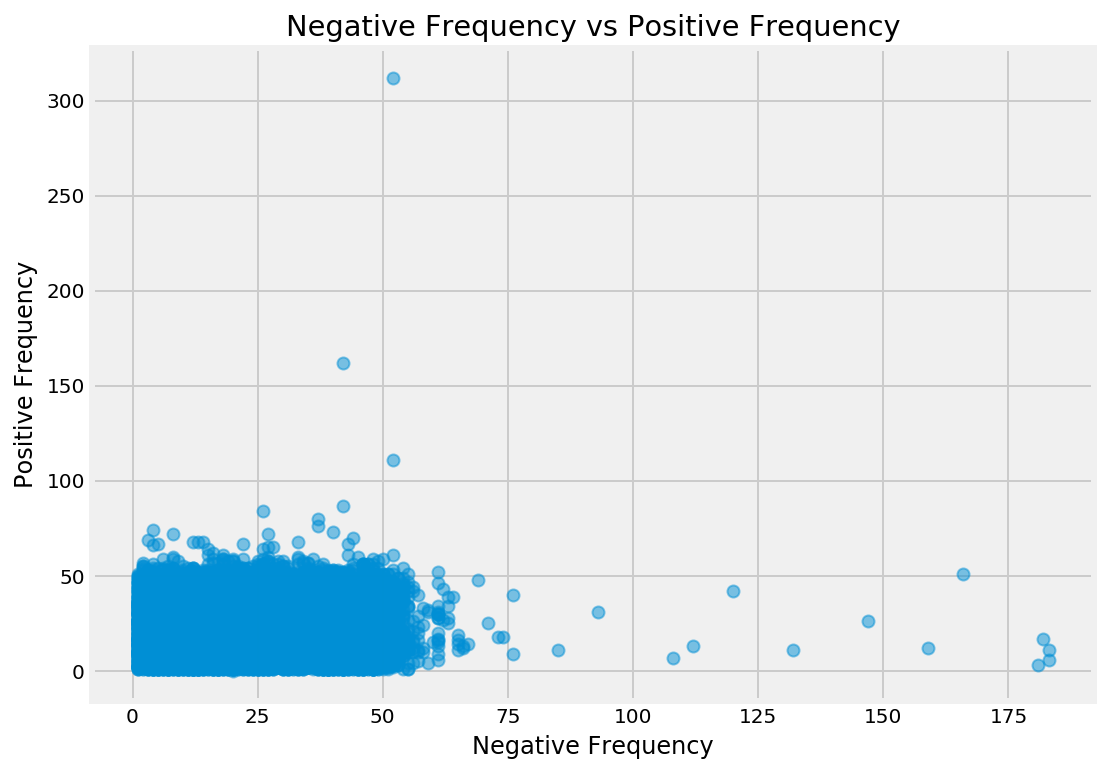

In [176]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_num_of_words", y="pos_num_of_words",fit_reg=False, scatter_kws={'alpha':0.5}, data=df_num_words)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [177]:
df_avg_wordlen = pd.DataFrame()
negs = negative_tweets['avg_word_length'].to_list()
pos = positive_tweets['avg_word_length'].to_list()
df_avg_wordlen['neg_avg_word_length'] = negs
df_avg_wordlen['pos_avg_word_length'] = pos
df_avg_wordlen

,neg_avg_word_length,pos_avg_word_length
0,5.148148,4.266667
1,5.090909,4.791667
2,4.729730,4.680851
3,4.208333,4.909091
4,5.277778,5.187500
...,...,...
18597,4.578947,4.714286
18598,4.448980,4.673913
18599,4.652174,4.285714
18600,5.000000,5.913043


Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

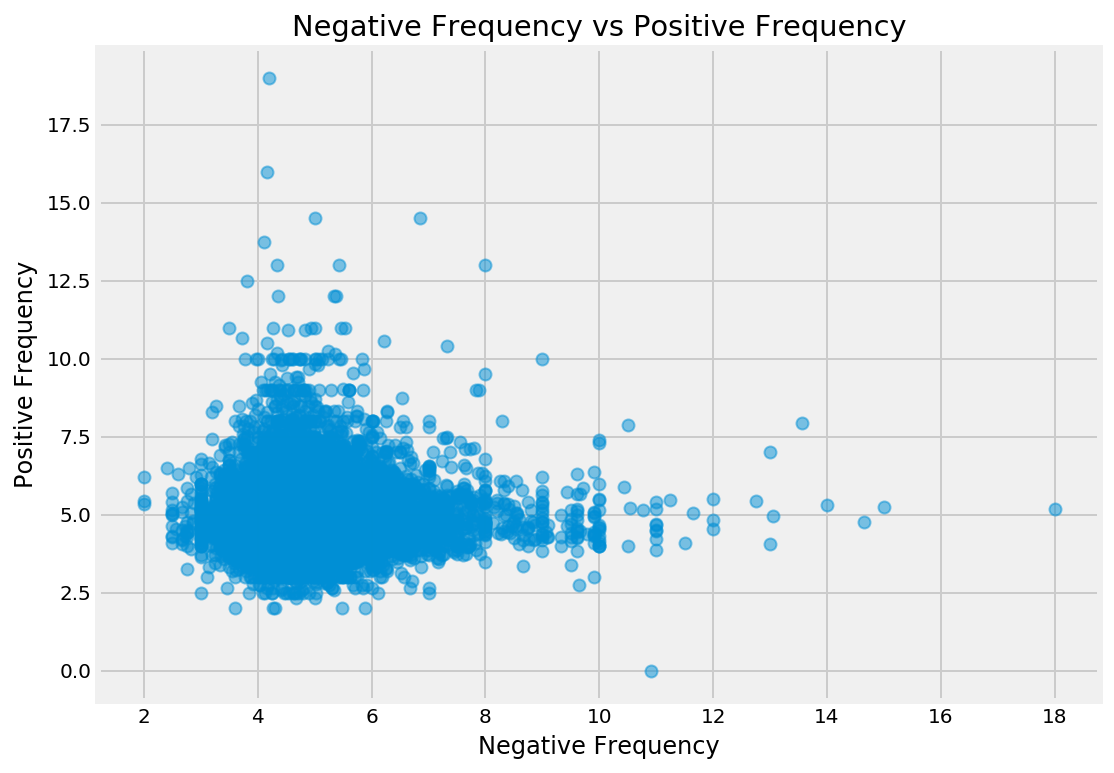

In [178]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_avg_word_length", y="pos_avg_word_length",fit_reg=False, scatter_kws={'alpha':0.5}, data=df_avg_wordlen)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [179]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+' #remove mentions
pat2 = r'https?://[^ ]+' #remove hyperlinks
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
#negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
#                 "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
#                 "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
#                 "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
#                 "mustn't":"must not"}
#neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated2(text):
    soup = BeautifulSoup(text, 'lxml') # remove html tags
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?") #remove byte order marks
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    stripped = re.sub(r'\@w+','',stripped)
    #lower_case = stripped.lower()
    #lower_case = emoji.demojize(lower_case, language='en')
    #neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    #letters_only = re.sub("[^a-zA-Z]", " ", stripped) #remove hashtag
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
#     words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
#     return (" ".join(words)).strip()

    return stripped

In [180]:
uncleaned_tweets = []
for tweet in tweets:
    uncleaned_tweets.append(tweet_cleaner_updated2(tweet))

In [181]:
cleaned_tweets[3]

'sugar and covid diabetes is target we eat too much sugar big usa years million diabetes were not covid year million diabetes cost billion is covid small hungary in diabetes not covid in million diabetes is covid'

In [182]:
uncleaned_tweets[3]
print(re.split(" |\n",uncleaned_tweets[3])[0] == '')

True


In [236]:
from advertools.emoji import extract_emoji

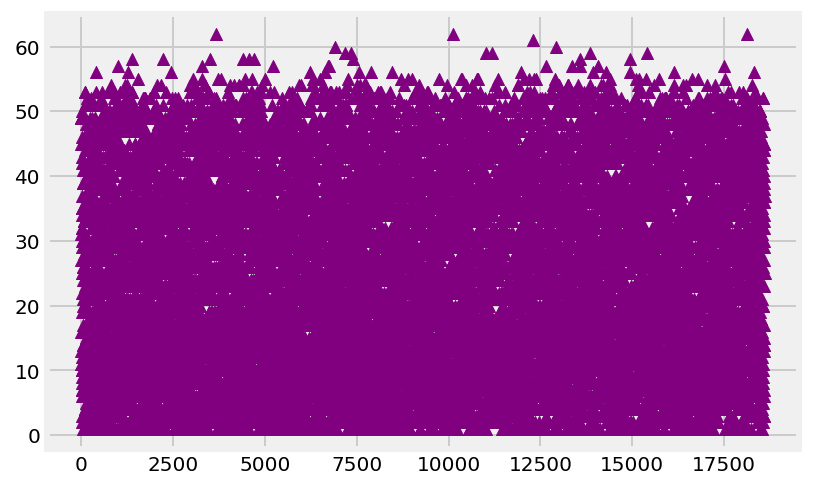

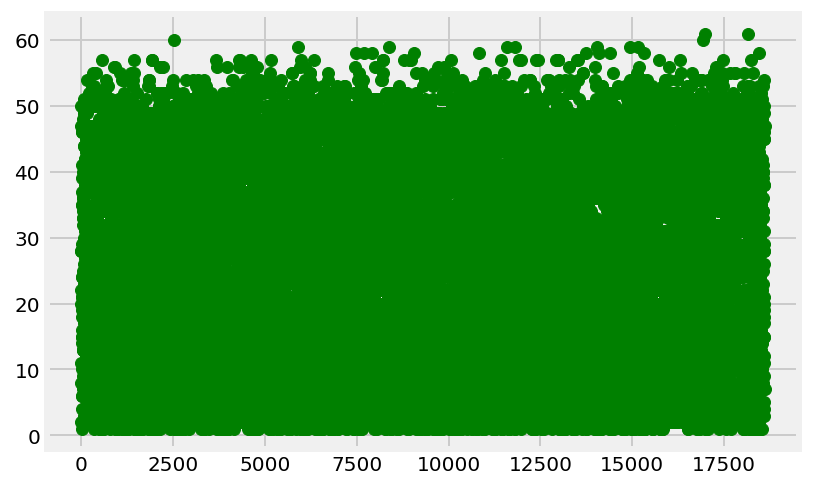

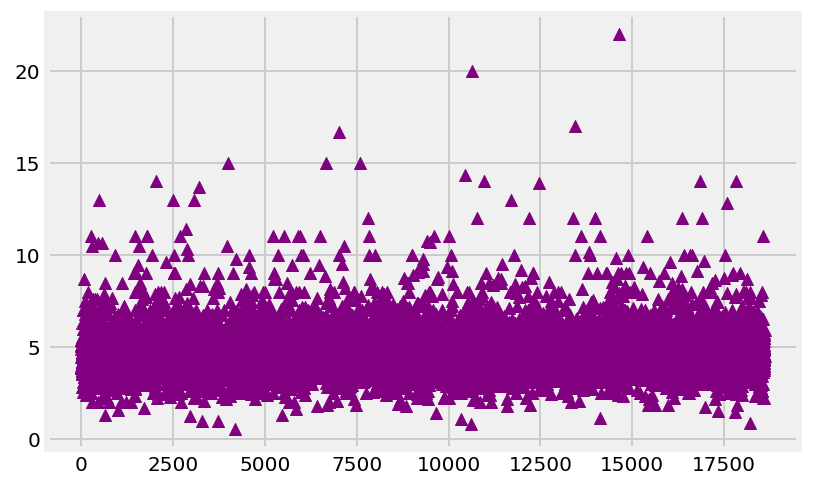

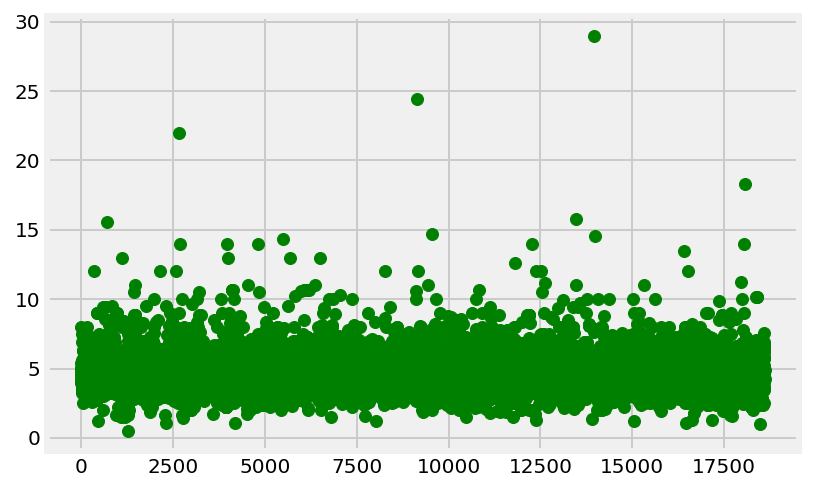

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

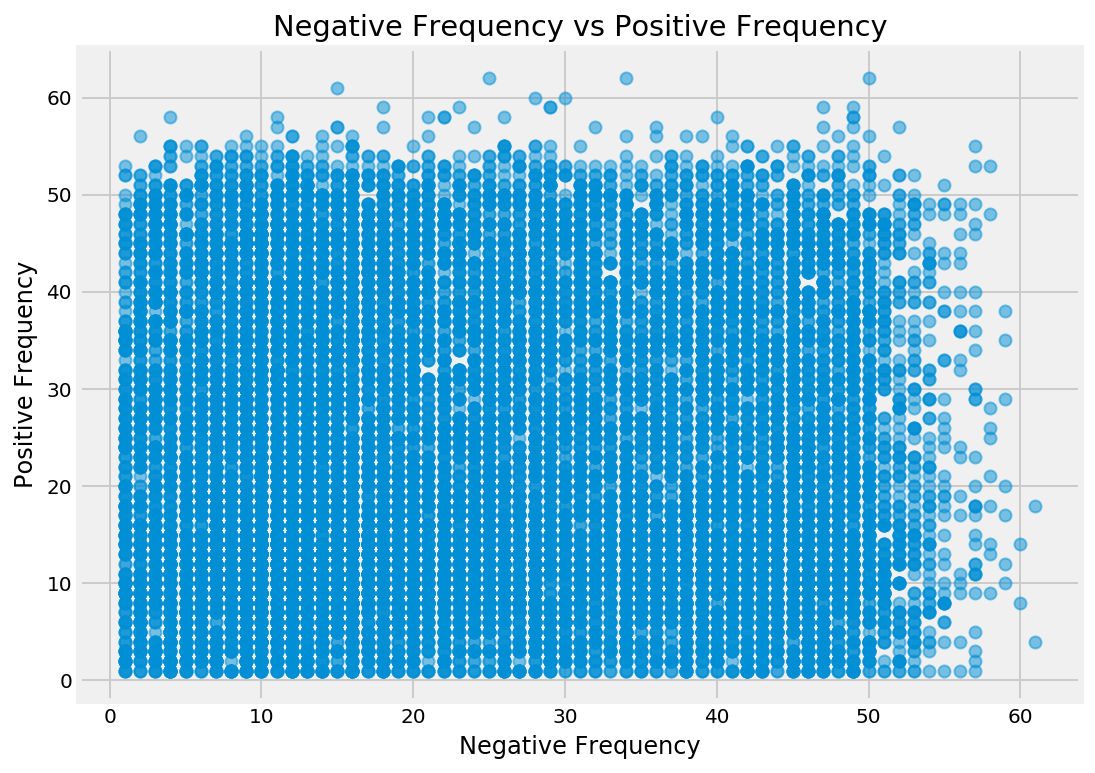

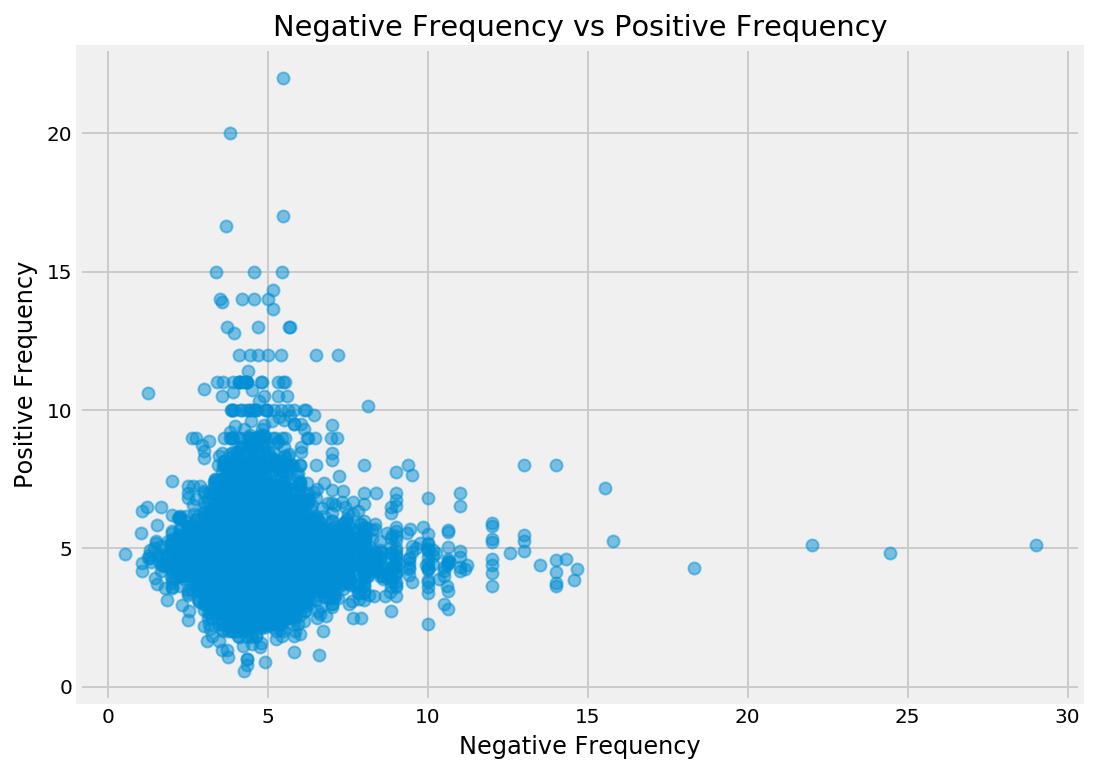

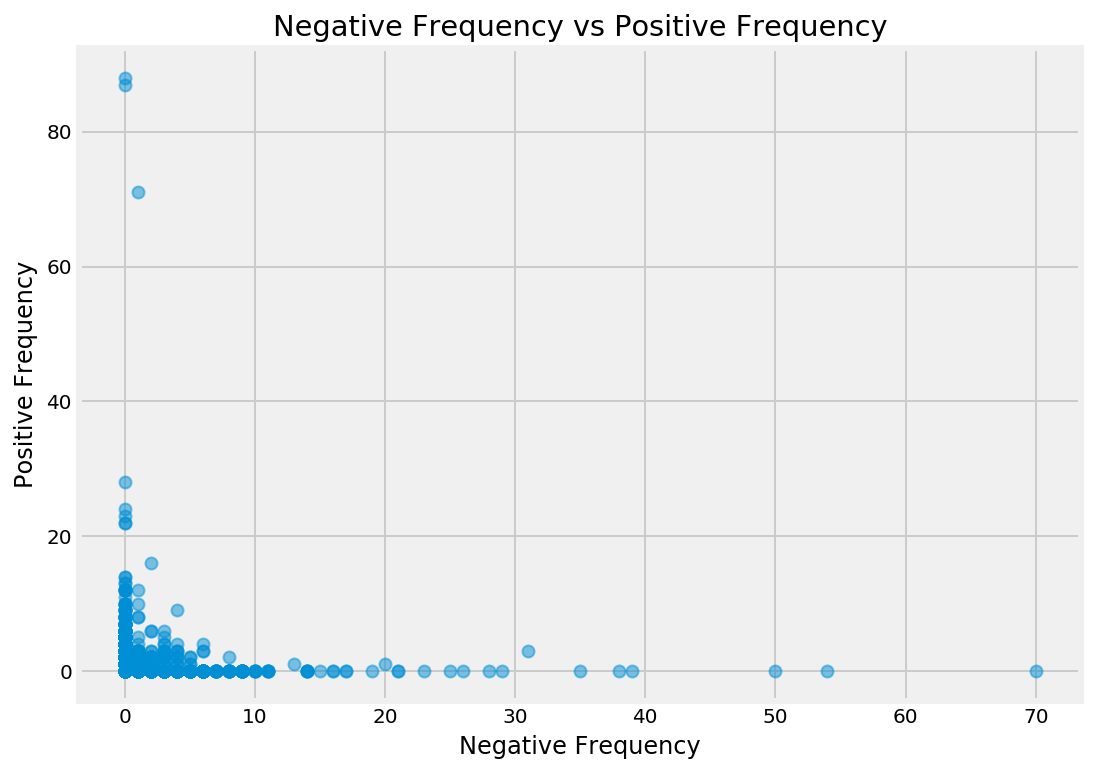

In [237]:
uncleaned_num_of_words = []
for tweet in uncleaned_tweets:
    length = 0
    for word in re.split(" |\n",tweet):
        if word != '':
            length += 1
    uncleaned_num_of_words.append(length)
    
uncleaned_avg_word_length = []
for tweet in uncleaned_tweets:
    if tweet != '':
        lengths = []
        for word in re.split(" |\n",tweet):
            if word != " ":
                lengths.append(len(word))
        uncleaned_avg_word_length.append(sum(lengths)/len(lengths))
    else:
        uncleaned_avg_word_length.append(0)
        
        
uncleaned_count_emoji = []
for tweet in uncleaned_tweets:
    count = 0
    for i in range(len(extract_emoji(tweet)['emoji_flat_text'])):
        count += 1
    uncleaned_count_emoji.append(count)
        



In [248]:
count_punctuation = lambda l1,l2: sum([1 for x in l1 if x in l2])
uncleaned_count_puncts = []
for tweet in uncleaned_tweets:
    uncleaned_count_puncts.append(count_punctuation(tweet,set(string.punctuation)))

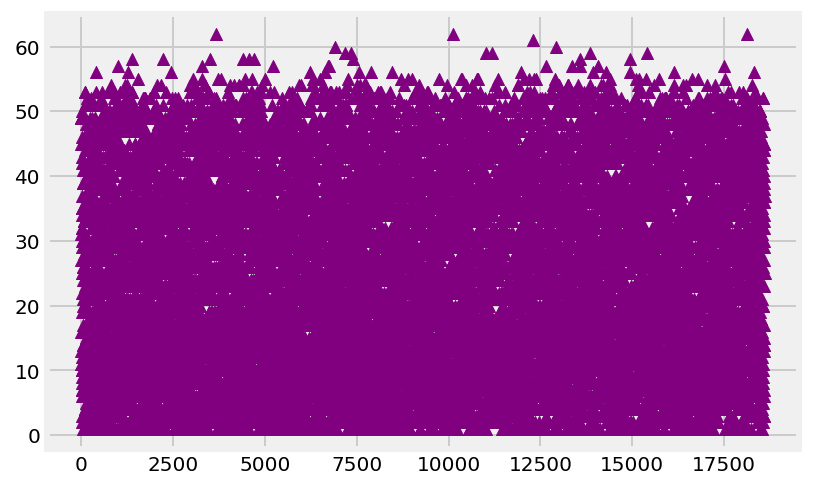

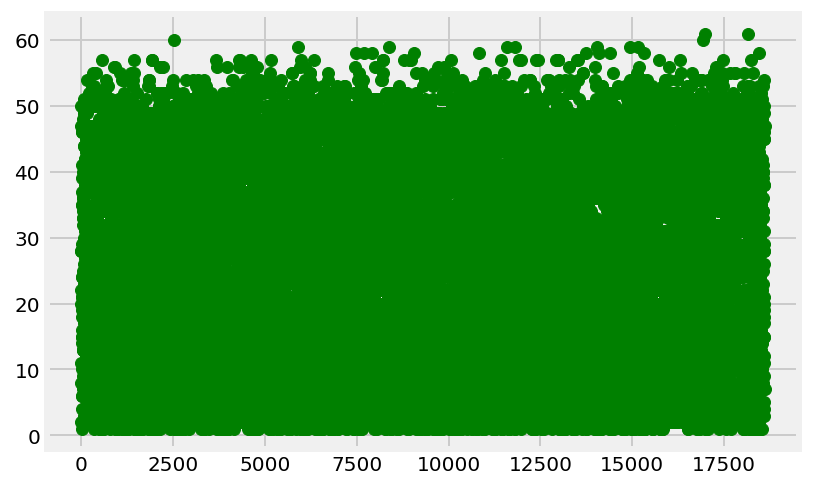

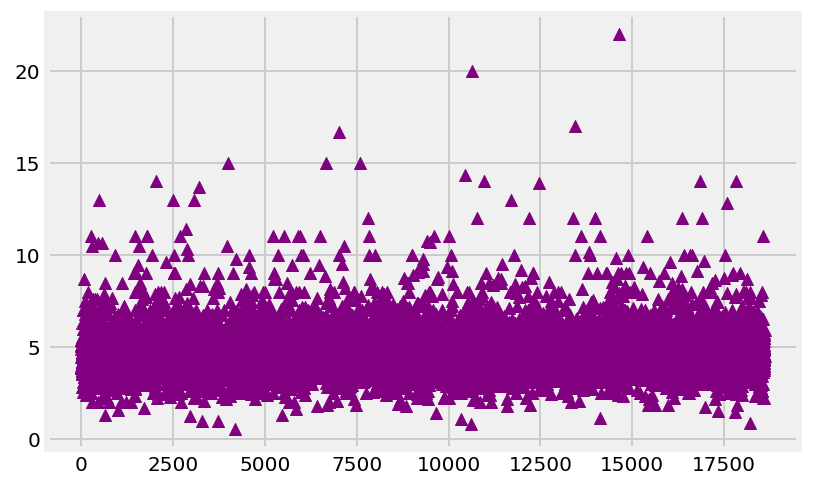

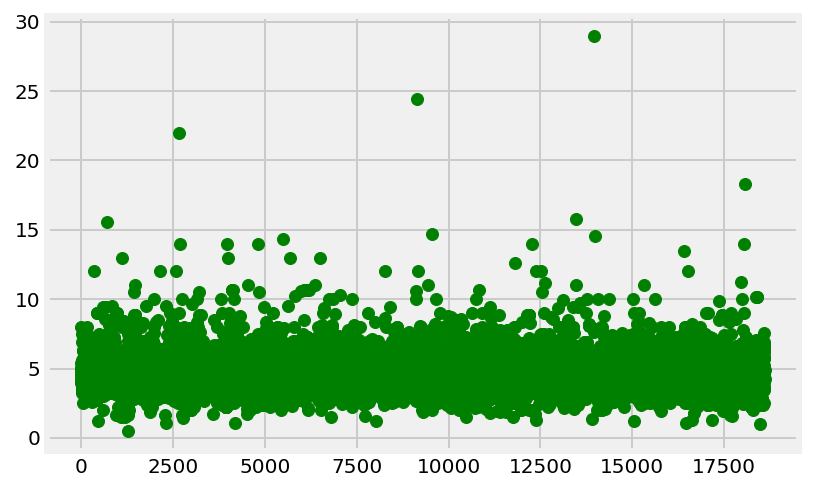

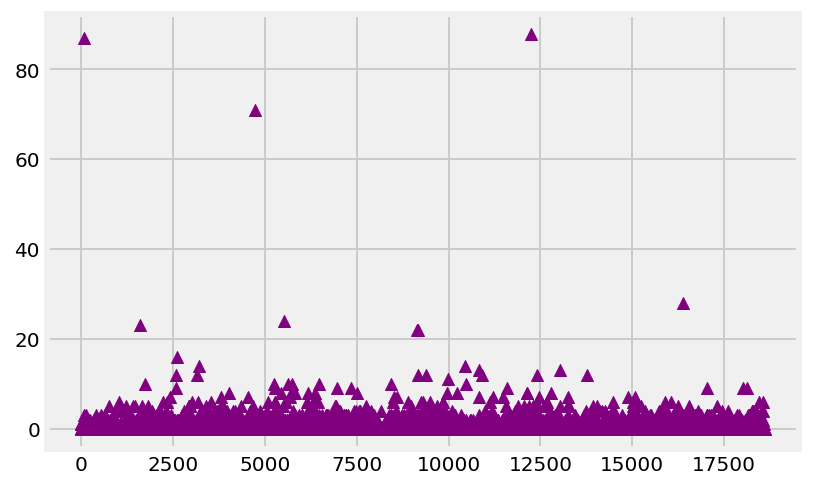

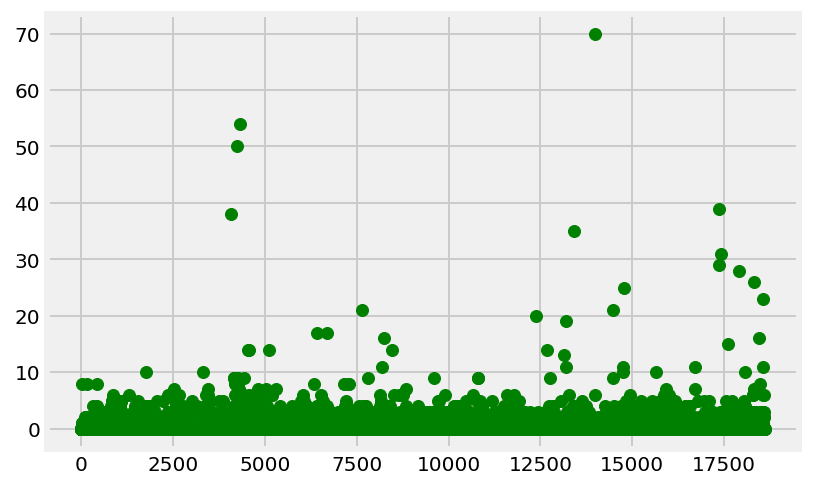

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

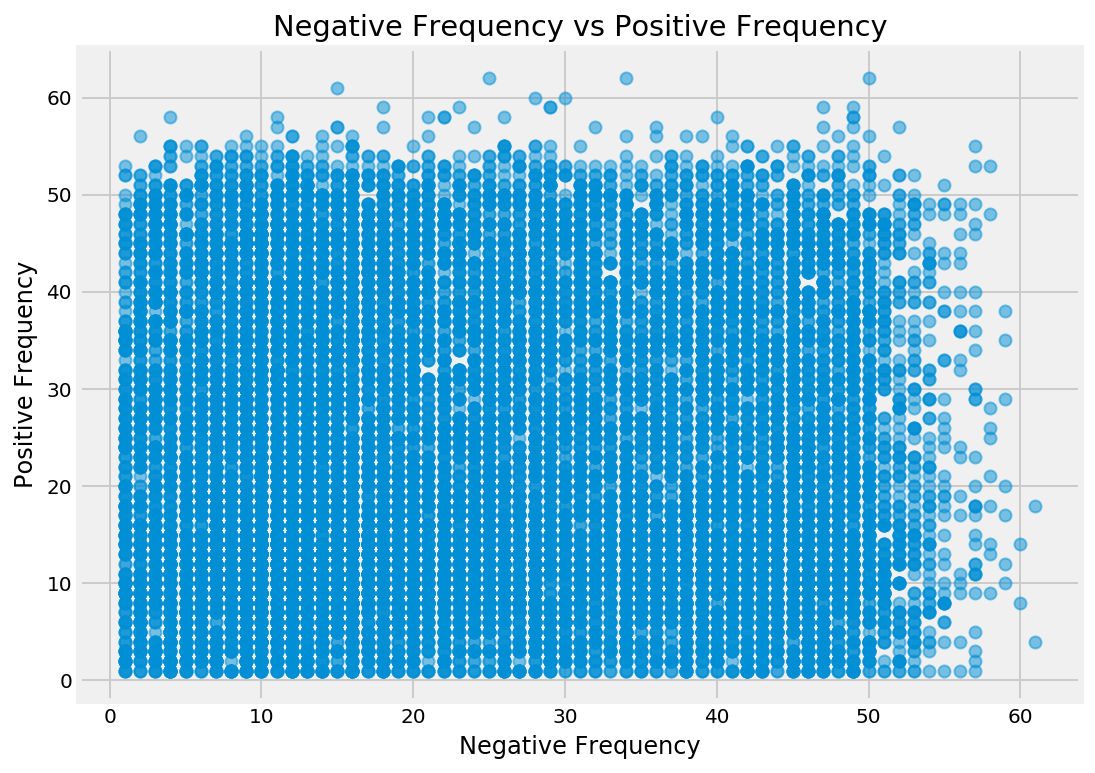

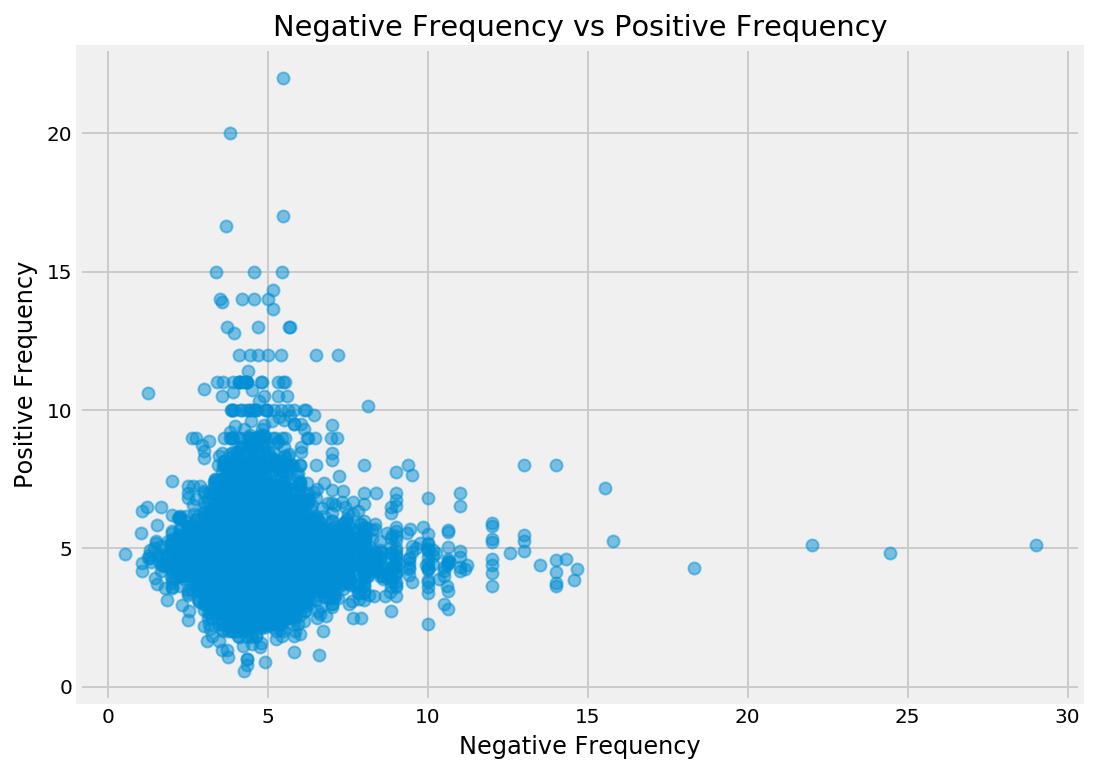

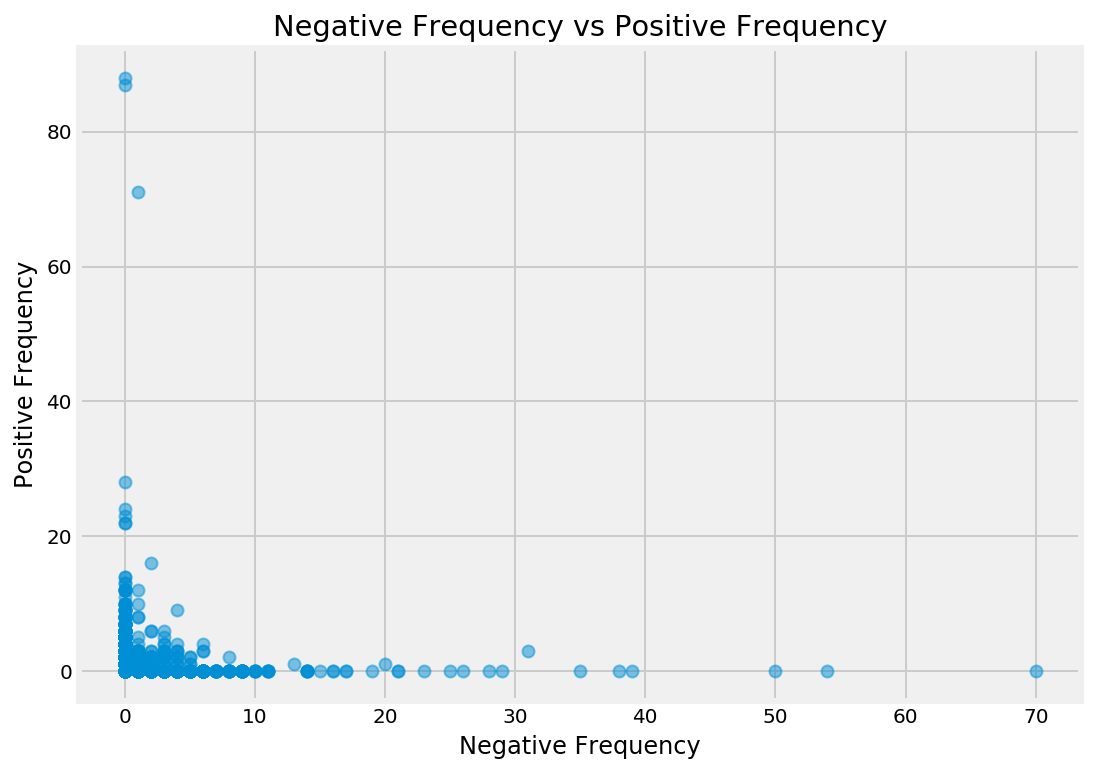

In [250]:
uncleaned_new_df = pd.DataFrame()
uncleaned_new_df['races'] = races
uncleaned_new_df['tweets'] = uncleaned_tweets
uncleaned_new_df['num_of_words'] = uncleaned_num_of_words
uncleaned_new_df['avg_word_length'] = uncleaned_avg_word_length
uncleaned_new_df['count_emoji'] = uncleaned_count_emoji
uncleaned_new_df['count_puncts'] = uncleaned_count_puncts

uncleaned_negative_tweets = uncleaned_new_df[uncleaned_new_df['races'] == 0]
uncleaned_positive_tweets = uncleaned_new_df[uncleaned_new_df['races'] == 1]

uncleaned_neg_tweets_num_of_words = uncleaned_negative_tweets['num_of_words'].to_list()
uncleaned_pos_tweets_num_of_words = uncleaned_positive_tweets['num_of_words'].to_list()
len(uncleaned_neg_tweets_num_of_words)
uncleaned_x_pos = [i for i in range(18602)]
uncleaned_x_neg = [i for i in range(18602)]
plt.scatter(uncleaned_x_pos, uncleaned_pos_tweets_num_of_words,  marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(uncleaned_x_neg, uncleaned_neg_tweets_num_of_words, marker='o',  color = 'green')
plt.show()

uncleaned_neg_tweets_avg_word_len = uncleaned_negative_tweets['avg_word_length'].to_list()
uncleaned_pos_tweets_avg_word_len = uncleaned_positive_tweets['avg_word_length'].to_list()
len(uncleaned_neg_tweets_num_of_words)
uncleaned_x_pos = [i for i in range(18602)]
uncleaned_x_neg = [i for i in range(18602)]
plt.scatter(uncleaned_x_pos, uncleaned_pos_tweets_avg_word_len,  marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(uncleaned_x_neg, uncleaned_neg_tweets_avg_word_len, marker='o', color = 'green')
plt.show()

uncleaned_df_emoji= pd.DataFrame()
uncleaned_negs = uncleaned_negative_tweets['count_emoji'].to_list()
uncleaned_pos = uncleaned_positive_tweets['count_emoji'].to_list()
uncleaned_df_emoji['neg_count_emoji'] = uncleaned_negs
uncleaned_df_emoji['pos_count_emoji'] = uncleaned_pos
uncleaned_df_emoji


uncleaned_x_pos = [i for i in range(18602)]
uncleaned_x_neg = [i for i in range(18602)]
plt.scatter(uncleaned_x_pos, uncleaned_pos,marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(uncleaned_x_neg, uncleaned_negs, marker='o', color = 'green')
plt.show()


uncleaned_df_num_words = pd.DataFrame()
uncleaned_negs = uncleaned_negative_tweets['num_of_words'].to_list()
uncleaned_pos = uncleaned_positive_tweets['num_of_words'].to_list()
uncleaned_df_num_words['neg_num_of_words'] = uncleaned_negs
uncleaned_df_num_words['pos_num_of_words'] = uncleaned_pos
uncleaned_df_num_words


import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_num_of_words", y="pos_num_of_words",fit_reg=False, scatter_kws={'alpha':0.5}, data=uncleaned_df_num_words)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')


uncleaned_df_avg_wordlen = pd.DataFrame()
uncleaned_negs = uncleaned_negative_tweets['avg_word_length'].to_list()
uncleaned_pos = uncleaned_positive_tweets['avg_word_length'].to_list()
uncleaned_df_avg_wordlen['neg_avg_word_length'] = uncleaned_negs
uncleaned_df_avg_wordlen['pos_avg_word_length'] = uncleaned_pos
uncleaned_df_avg_wordlen

import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_avg_word_length", y="pos_avg_word_length",fit_reg=False, scatter_kws={'alpha':0.5}, data=uncleaned_df_avg_wordlen)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_count_emoji", y="pos_count_emoji",fit_reg=False, scatter_kws={'alpha':0.5}, data=uncleaned_df_emoji)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

 

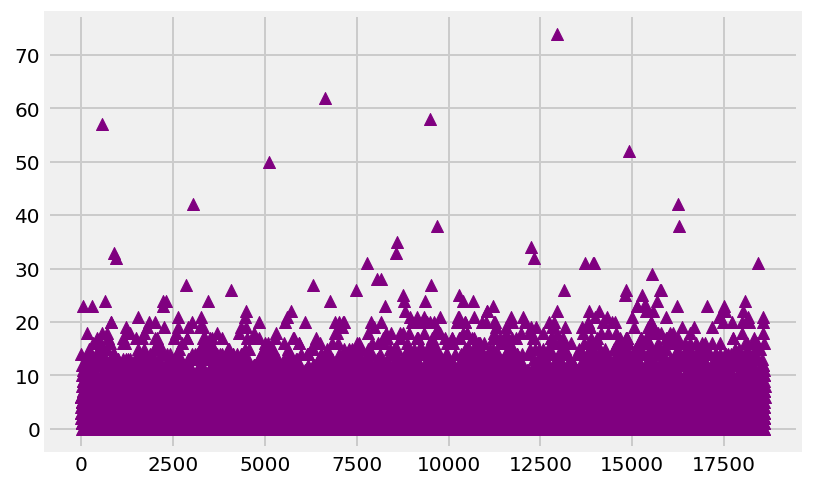

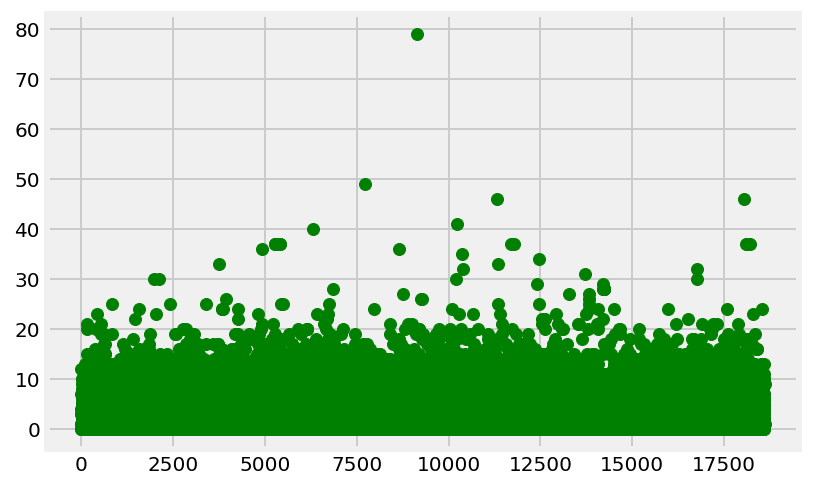

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

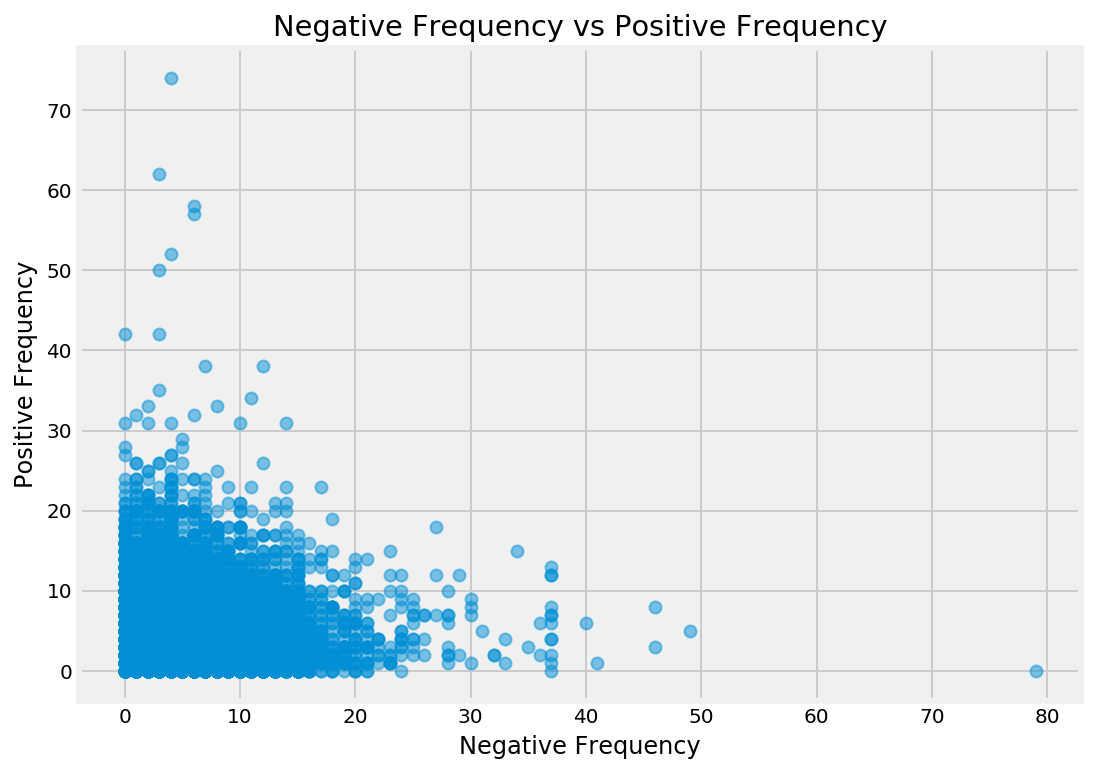

In [251]:
uncleaned_df_puncts= pd.DataFrame()
uncleaned_negs = uncleaned_negative_tweets['count_puncts'].to_list()
uncleaned_pos = uncleaned_positive_tweets['count_puncts'].to_list()
uncleaned_df_puncts['neg_count_puncts'] = uncleaned_negs
uncleaned_df_puncts['pos_count_puncts'] = uncleaned_pos

uncleaned_x_pos = [i for i in range(18602)]
uncleaned_x_neg = [i for i in range(18602)]
plt.scatter(uncleaned_x_pos, uncleaned_pos,marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(uncleaned_x_neg, uncleaned_negs, marker='o', color = 'green')
plt.show()


import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_count_puncts", y="pos_count_puncts",fit_reg=False, scatter_kws={'alpha':0.5}, data=uncleaned_df_puncts)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')   

In [238]:
print(uncleaned_count_emoji)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 8, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [246]:
s = uncleaned_tweets[989]
s

'#DishNetwork CEO is an Ass!!!  #removing channels in a pandemic!'

In [245]:
count_punctuation(s,set(string.punctuation))     

6